<a href="https://colab.research.google.com/github/ClarenceKaranja/ROBUST-PORTFOLIO-OPTIMIZATION-WITH-RISK-DECAY/blob/main/Markowitz_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly_express
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td
from scipy import optimize


In [2]:
import yfinance as yf
from datetime import datetime as dt, timedelta as td

end = dt.today()
start = end - td(days=2000)
stocks = 'AMZN TSLA META MSFT NVDA AVGO FICO'.split()

# Fetch historical data
df = yf.download(stocks, start=start, end=end)

# Print the DataFrame
print(df)

[*********************100%%**********************]  7 of 7 completed
             Adj Close                                                   \
                  AMZN        AVGO         FICO        META        MSFT   
Date                                                                      
2018-06-04   83.263496  213.137436   189.789993  193.279999   95.761719   
2018-06-05   84.817497  213.871674   191.770004  192.940002   96.251518   
2018-06-06   84.787498  217.385864   192.860001  191.339996   96.534081   
2018-06-07   84.464996  218.342819   192.830002  188.179993   95.017647   
2018-06-08   84.199501  212.807541   198.949997  189.100006   95.724068   
...                ...         ...          ...         ...         ...   
2023-11-17  145.179993  977.729980  1042.270020  335.040009  369.850006   
2023-11-20  146.130005  995.710022  1051.449951  339.970001  377.440002   
2023-11-21  143.899994  981.200012  1054.900024  336.980011  373.070007   
2023-11-22  146.710007  972.000

In [3]:
# remove multilevel
df.columns = ['_'.join(col) for col in df.columns]

# Just study adj close
df = df.iloc[:,:7]

In [4]:
df.head()

,Adj Close_AMZN,Adj Close_AVGO,Adj Close_FICO,Adj Close_META,Adj Close_MSFT,Adj Close_NVDA,Adj Close_TSLA
Date,,,,,,,
2018-06-04,83.263496,213.137436,189.789993,193.279999,95.761719,65.602425,19.782667
2018-06-05,84.817497,213.871674,191.770004,192.940002,96.251518,65.656906,19.408667
2018-06-06,84.787498,217.385864,192.860001,191.339996,96.534081,65.676712,21.299999
2018-06-07,84.464996,218.342819,192.830002,188.179993,95.017647,65.119385,21.072666
2018-06-08,84.199501,212.807541,198.949997,189.100006,95.724068,64.965820,21.177334


In [5]:
px.line(df * 100 / df.iloc[0])

In [6]:
# Filter the data frame to include only the data for the year 2018
df_2023 = df[df.index.year == 2023]

# Plot the line chart for the filtered data frame
fig = px.line(df_2023 * 100 / df_2023.iloc[0])
fig.show()

In [7]:
ret_port = df.pct_change()
px.line(ret_port)

In [8]:
# Filter the data frame to include only the data for the year 2018
df_2018 = df[df.index.year == 2018]

# Calculate the percentage change of the filtered data frame
ret_port_2018 = df_2018.pct_change()

# Plot the line chart for the filtered data frame
fig = px.line(ret_port_2018)
fig.show()


# MEAN VARIANCE OPTIMIZATION/ MVO

In [9]:
#Setting Random Seed, When you set a random seed, it ensures that if you run the same code again, you'll get the same random numbers.
np.random.seed(1)

# Generating Random Weights
#This line generates an array of random numbers (weights) for each security. (4, 1) specifies that you want a 4x1 matrix (column vector) of random numbers
weights = np.random.random((7,1))

# Normalizing Weights
# line normalizes the weights so that they sum up to 1. This makes them represent proportions of the total investment.
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# Log Returns Calculation
log_ret = np.log(df / df.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk) Calculation
# This calculates the expected volatility of the portfolio, a measure of risk. It involves the covariance matrix of log returns.
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio Calculation:
# This calculates the Sharpe ratio, a measure of the risk-adjusted return. It's the ratio of expected return to expected volatility.
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [2.23586532e-01 3.86202295e-01 6.13221088e-05 1.62095742e-01
 7.86832356e-02 4.95073783e-02 9.98634946e-02]

Expected return of the portfolio is : 0.23021773356976488

Volatility of the portfolio: 0.3235232979278704

Sharpe ratio of the portfolio: 0.7115955328233949


Monte Carlo Simulation

In [10]:
# setting up the parameters for the Monte Carlo Simulation:
# number of simulation
n = 100_000

# Initialization of Arrays
# initialize arrays to store the weights, volatility, Sharpe ratio, and return for each simulated portfolio.
port_weights = np.zeros(shape=(n,len(df.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

In [11]:
# Number of Securities (the number of securities in the dataset)
num_securities = len(df.columns)
num_securities

7

In [12]:
# This loop performs the Monte Carlo Simulation:
for i in range(n):
    # Randomly Generate Portfolio Weights
    weights = np.random.random(7)

    # normalizes the weights to ensure that the sum is equal to 1
    weights /= np.sum(weights)

    # stores the generated weights for each security in the port_weights array.
    port_weights[i,:] = weights

    # calculates the expected return for the portfolio based on the randomly generated weights.
    exp_ret = log_ret.mean().dot(weights)*252

    # stores the calculated expected return in the port_return array.
    port_return[i] = exp_ret

    # calculates the expected volatility (risk) for the portfolio based on the randomly generated weights.
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))

    # stores the calculated expected volatility in the port_volatility array.
    port_volatility[i] = exp_vol

    #  calculates the Sharpe ratio for the portfolio based on the randomly generated weights.
    sr = exp_ret / exp_vol

    # stores the calculated Sharpe ratio in the port_sr array.
    port_sr[i] = sr

In [13]:
# identifys the portfolio with the maximum Sharpe Ratio (SR) from the Monte Carlo Simulation results
# Index of Maximum Sharpe Ratio
# finds the maximum Sharpe Ratio from the array port_sr, which stores the Sharpe Ratios for each simulated portfolio.
max_sr = port_sr.max()
print(max_sr)
# Index of Maximum Sharpe Ratio:
# finds the index (or position) of the maximum Sharpe Ratio in the array port_sr. This index will be used to retrieve the corresponding values for return and volatility.
ind = port_sr.argmax()
print(ind)
# Return and Volatility at Maximum Sharpe Ratio
# lines extract the return and volatility of the portfolio that corresponds to the maximum Sharpe Ratio.
max_sr_ret = port_return[ind]
print(max_sr_ret)

max_sr_vol = port_volatility[ind]
print(max_sr_vol)

0.9482210540348893
63924
0.32352924518775517
0.34119601522352516


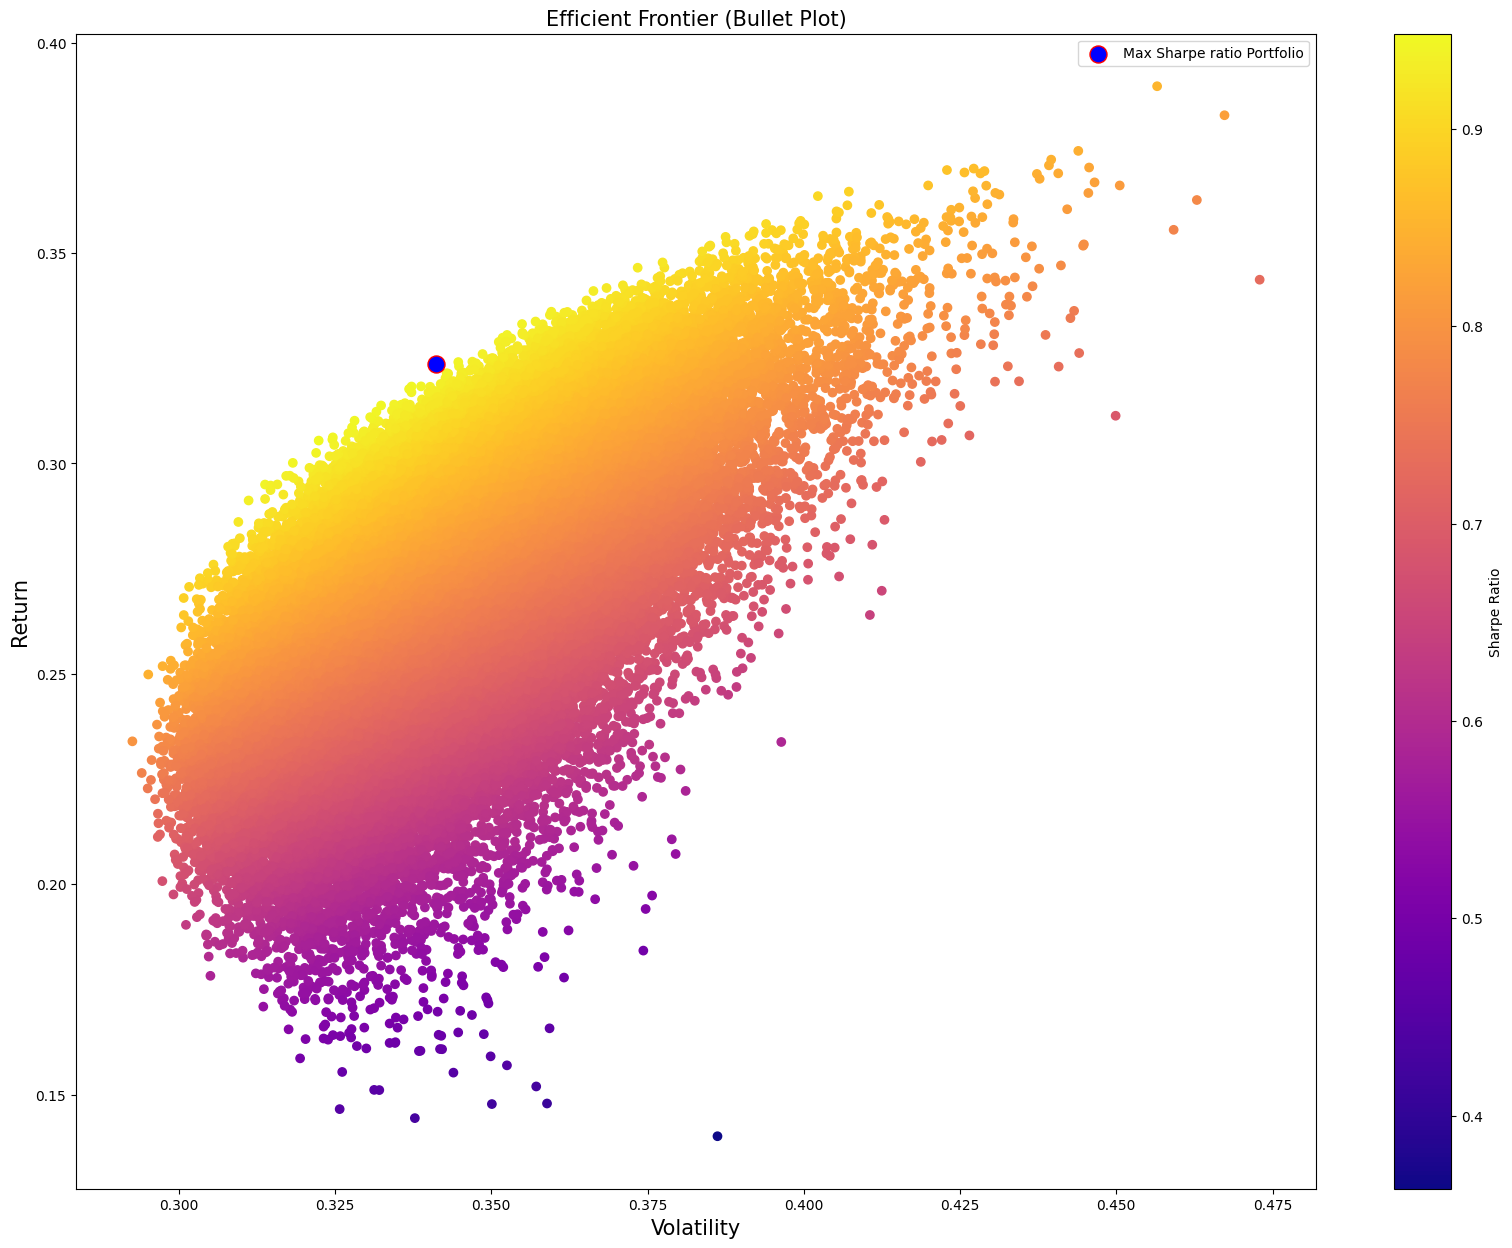

In [14]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

THE PORTFOLIO YOU SHOULD HAVE IF YOU ARE USING THE MVO

In [15]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz(mvo) optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

0.21 % of AMZN should be bought.
8.74 % of TSLA should be bought.
27.25 % of META should be bought.
0.33 % of MSFT should be bought.
35.48 % of NVDA should be bought.
3.42 % of AVGO should be bought.
24.56 % of FICO should be bought.

Markowitz(mvo) optimal portfolio return is : 32.35% with volatility 0.34119601522352516


## MEAN VARIANCE OPTIMIZATION WITH RISK DECAY


In [16]:
# Function to calculate the risk decay based on the provided model
def calculate_risk_decay(initial_risk, decay_rate, time):
    return initial_risk * np.exp(-decay_rate * time)

# Set the decay rate
custom_decay_rate = 0.05

# Modified function to get expected return and volatility considering risk decay
def get_ret_vol_sr_custom(weights, time):
    weights = np.array(weights)
    log_returns = np.log(df / df.shift(1))
    decayed_risk = calculate_risk_decay(log_returns.std(), custom_decay_rate, time)
    ret = log_returns.mean().dot(weights) * 252
    vol = np.sqrt(weights.T.dot(252 * (log_returns.cov() * decayed_risk).dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

In [17]:
# Number of simulations
num_simulations = 100_000

# Initialize arrays to store results
custom_port_weights = np.zeros(shape=(num_simulations, len(df.columns)))
custom_port_volatility = np.zeros(num_simulations)
custom_port_sr = np.zeros(num_simulations)
custom_port_return = np.zeros(num_simulations)

In [18]:
# Number of securities
num_custom_securities = len(df.columns)
print(num_custom_securities)
# Set the initial date and time
custom_start_date = dt.today() - td(days=2000)
print(custom_start_date)

7
2018-06-04 15:39:25.810812


Monte Carlo Simulation

In [19]:
# Monte Carlo Simulation
for i in range(num_simulations):
    # Weight each security
    custom_weights = np.random.random(7)
    custom_weights /= np.sum(custom_weights)
    custom_port_weights[i, :] = custom_weights

    # Calculate the time decay
    custom_time_decay = i / num_simulations  # Adjust as needed based on the desired time decay logic

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    custom_exp_ret = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[0]
    custom_port_return[i] = custom_exp_ret

    # Exp Volatility (Risk)
    custom_exp_vol = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[1]
    custom_port_volatility[i] = custom_exp_vol

    # Sharpe ratio
    custom_sr = get_ret_vol_sr_custom(custom_weights, custom_time_decay)[2]
    custom_port_sr[i] = custom_sr


In [20]:
# Index of max Sharpe Ratio
custom_max_sr = custom_port_sr.max()
custom_ind = custom_port_sr.argmax()

# Return and Volatility at Max SR
custom_max_sr_ret = custom_port_return[custom_ind]
custom_max_sr_vol = custom_port_volatility[custom_ind]

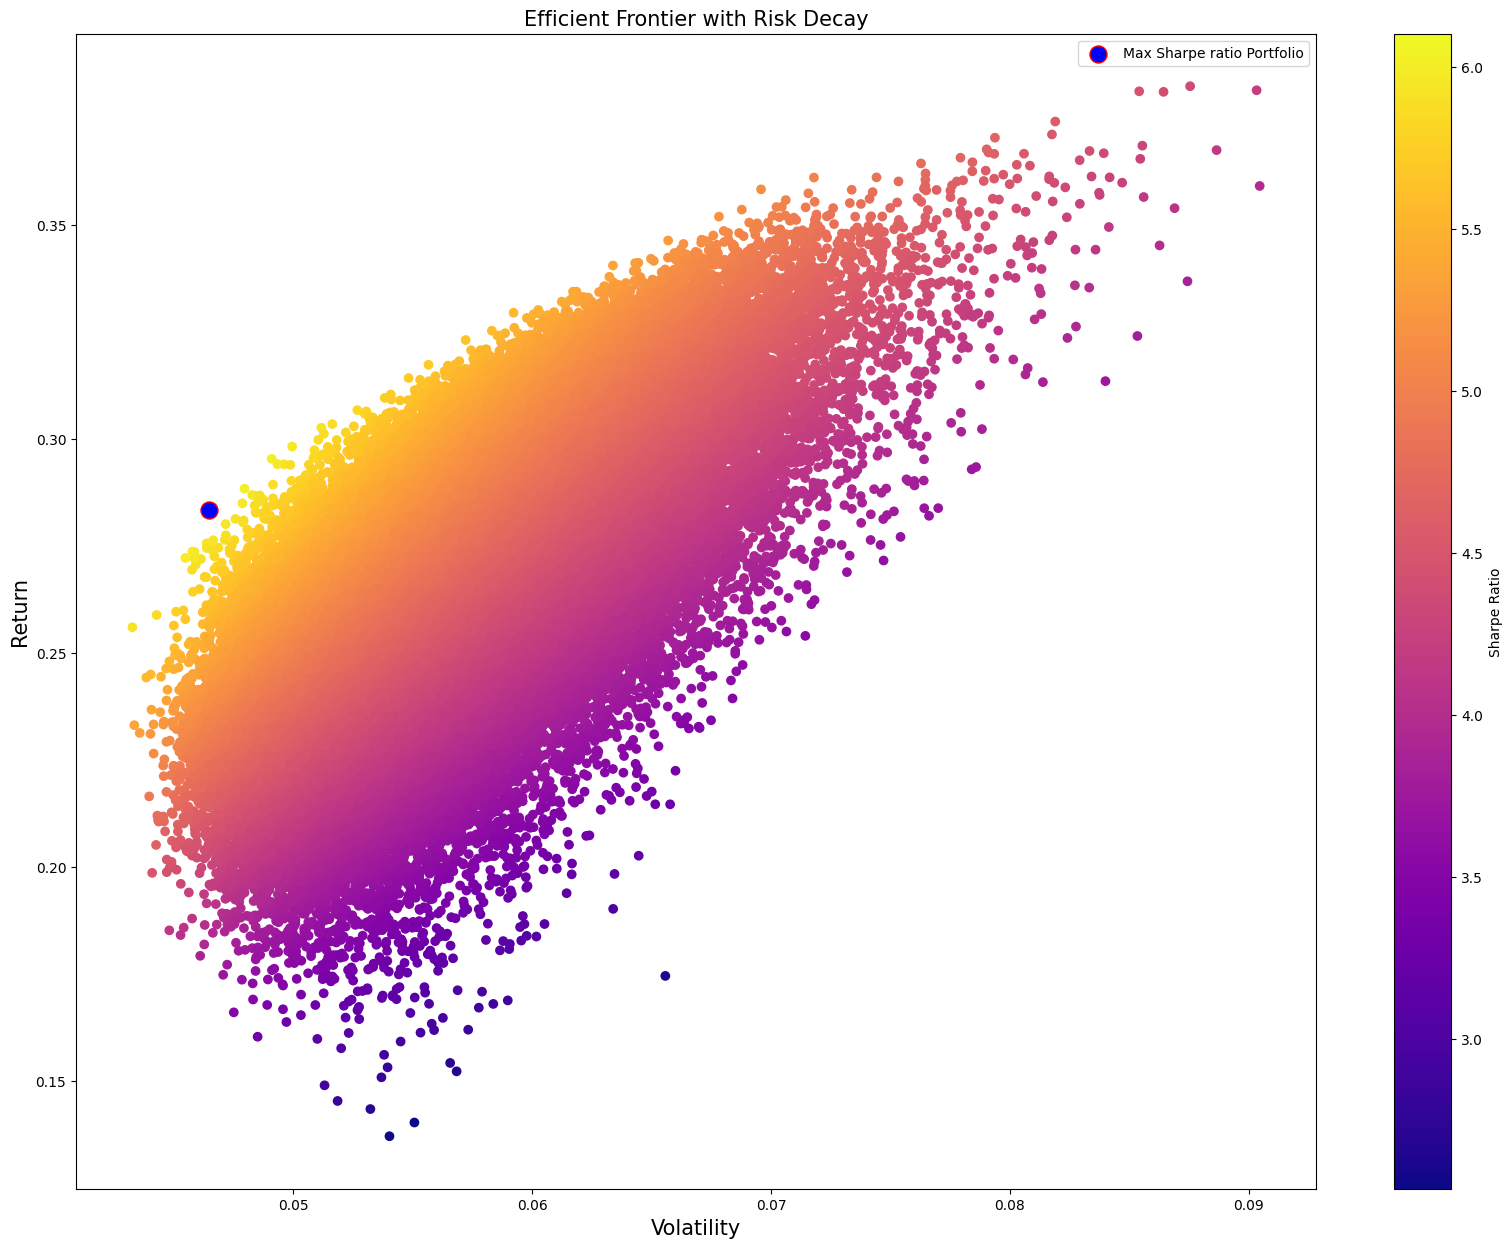

In [21]:
# Plot the efficient frontier
plt.figure(figsize=(20, 15))
plt.scatter(custom_port_volatility, custom_port_return, c=custom_port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier with Risk Decay', fontsize=15)
plt.scatter(custom_max_sr_vol, custom_max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max Sharpe ratio Portfolio')
plt.legend()
plt.show()

In [22]:
for weight, stock in zip(port_weights[ind],stocks):
    print(f'{round(weight * 100, 2)} % of {stock} should be bought.')

# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

# Display weights for the optimal portfolio
for weight, stock in zip(custom_port_weights[ind], stocks):
    print(f'{round(weight * 100, 2)}% of {stock} should be bought.')

# Display the optimal portfolio return
print(f'\nMarkowitz with risk decay optimal portfolio return is: {round(custom_max_sr_ret * 100, 2)}% with volatility \
{custom_max_sr_vol}')


0.21 % of AMZN should be bought.
8.74 % of TSLA should be bought.
27.25 % of META should be bought.
0.33 % of MSFT should be bought.
35.48 % of NVDA should be bought.
3.42 % of AVGO should be bought.
24.56 % of FICO should be bought.

Markowitz optimal portfolio return is : 32.35% with volatility 0.34119601522352516
8.62% of AMZN should be bought.
15.89% of TSLA should be bought.
9.26% of META should be bought.
16.0% of MSFT should be bought.
11.6% of NVDA should be bought.
18.13% of AVGO should be bought.
20.51% of FICO should be bought.

Markowitz with risk decay optimal portfolio return is: 28.35% with volatility 0.04644246360663287


In [23]:
import scipy.stats as stats
import numpy as np

# Sample data
returns_sample1 = [28.58]
volatility_sample1 = [0.3187564486350622]

returns_sample2 = [25.27]
volatility_sample2 = [0.04246773868853342]
# Combine all data points for each sample
all_returns = np.concatenate([returns_sample1, returns_sample2])
all_volatility = np.concatenate([volatility_sample1, volatility_sample2])

# Assign group labels
group_labels_returns = ['Sample1'] * len(returns_sample1) + ['Sample2'] * len(returns_sample2)
group_labels_volatility = ['Sample1'] * len(volatility_sample1) + ['Sample2'] * len(volatility_sample2)

# Perform Kruskal-Wallis Test for returns
kw_stat_returns, p_value_kw_returns = stats.kruskal(returns_sample1, returns_sample2)

# Perform Kruskal-Wallis Test for volatilities
kw_stat_volatility, p_value_kw_volatility = stats.kruskal(volatility_sample1, volatility_sample2)

# Output the results
print(f'Kruskal-Wallis Test for Returns: H-statistic = {kw_stat_returns}, p-value = {p_value_kw_returns}')
print(f'Kruskal-Wallis Test for Volatilities: H-statistic = {kw_stat_volatility}, p-value = {p_value_kw_volatility}')


Kruskal-Wallis Test for Returns: H-statistic = 1.0, p-value = 0.31731050786291115
Kruskal-Wallis Test for Volatilities: H-statistic = 1.0, p-value = 0.31731050786291115
